In [1]:
import scipy
import os
import numpy as np
import mne
import matplotlib.pyplot as plt

In [45]:
class Recording:
    # Data paths
    root = 'C:/Users/annej/OneDrive/Documents/GitHub/eeg_stress_detection/Data'
    dir_raw = root + '/ica_filtered_data'
    dir_filtered = root + '/ica_filtered_data_2'
    
    # Parameters
    Fs = 128
    ch_type = 'eeg'
    n_channels = 32
    
    def __init__(self, data_type, sub_nr, trial_nr):
        self.data_type = data_type
        self.sub_nr = sub_nr
        self.trial_nr = trial_nr
        
        # Load data
        self.load_data()

        # Create mne RawArray
        info = mne.create_info(ch_names = self.get_channels(), sfreq = self.Fs, ch_types = self.ch_type)
        self.raw_arr = mne.io.RawArray(self.data, info, first_samp=0, copy='auto', verbose=None)
        
        
        # Set montage
        montage = mne.channels.make_standard_montage('standard_1020')
        self.raw_arr.set_montage(montage)   
    #----------------------------------------------------------------------------------------------------
    
    def load_data(self):
        dir = self.dir_raw
        data_key = 'Clean_data'
            
        # Load one recording
        for filename in os.listdir(dir):
            if f"{self.data_type}_sub_{self.sub_nr}_trial{self.trial_nr}" in filename:
                f = os.path.join(dir, filename)
                self.data = scipy.io.loadmat(f)[data_key]
                break
  

    def save_data(self):
        title = f"{self.data_type}_sub_{self.sub_nr}_trial{self.trial_nr}"
        clean_data = self.reconst_arr.to_data_frame(scalings=1)
        clean_data = clean_data.to_numpy()
        clean_data = np.transpose(clean_data)
        clean_dict = {
            "Clean_data" : clean_data[1:, :]  #First column of dataFrames is not data
        }
        scipy.io.savemat(f'{self.dir_filtered}/{title}.mat', clean_dict)
    
    def get_channels(self):
        coordinates_file = os.path.join(self.root, "Coordinates.locs") 

        channel_names = []

        with open(coordinates_file, "r") as file:
            for line in file:
                elements = line.split()
                channel = elements[-1]
                channel_names.append(channel)
                
        return channel_names
    
    def init_ICA(self):
        self.ica = mne.preprocessing.ICA(n_components=15, max_iter=10000, random_state=97)
        self.ica.fit(self.raw_arr)
        
    def plot_sources(self):
        self.ica.plot_sources(self.raw_arr, title=f'ICA components S{self.sub_nr} T{self.trial_nr}', show_scrollbars=False)
        self.ica.plot_components(colorbar=True, reject='auto')
        
    def plot_properties(self, components):
        self.ica.plot_properties(self.raw_arr, picks = components)
        
    def test_exclude(self, components):
        self.ica.plot_overlay(self.raw_arr, exclude=components, picks='eeg')

    def exclude_ICA(self, components):
        self.ica.exclude = components
        self.reconst_arr = self.raw_arr.copy()
        self.ica.apply(self.reconst_arr)
    
    def plot(self, data_type, save=False):
        if data_type == 'ica' and save == True:
            with mne.viz.use_browser_backend('matplotlib'):
                title = f"ICA components S{self.sub_nr} T{self.trial_nr}"
                fig = self.ica.plot_sources(self.raw_arr, title=title, 
                                            show_scrollbars=False)
                fig.savefig(f'{self.root}/Figures/{title}.png') 

        else:
            if data_type == 'raw':
                data = self.raw_arr
                title = f"Raw data S{self.sub_nr} T{self.trial_nr}"
            elif data_type == 'reconstructed':
                data = self.reconst_arr
                title = f"Reconstructed data S{self.sub_nr} T{self.trial_nr}"
                pass

            if not save:
                data.plot(duration = 25, title=title, n_channels=self.n_channels, scalings=18, show_scrollbars=False)
            else:
                with mne.viz.use_browser_backend('matplotlib'):
                    #scalings = 18 is good
                    fig = data.plot(duration = 25, title=f'{title}', n_channels=self.n_channels, scalings=18, show_scrollbars=False)
                    fig.savefig(f'{self.root}/Figures/{title}.png') 



In [212]:
test = Recording(data_type = 'Arithmetic', sub_nr = 11, trial_nr = 1)


C:/Users/annej/OneDrive/Documents/GitHub/eeg_stress_detection/Data/ica_filtered_data\Arithmetic_sub_11_trial1.mat
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


In [47]:
#test.plot('raw')

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components


C:\Users\annej\AppData\Local\Temp\ipykernel_7116\3609260261.py:68: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  self.ica.fit(self.raw_arr)


Fitting ICA took 0.4s.
Creating RawArray with float64 data, n_channels=15, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


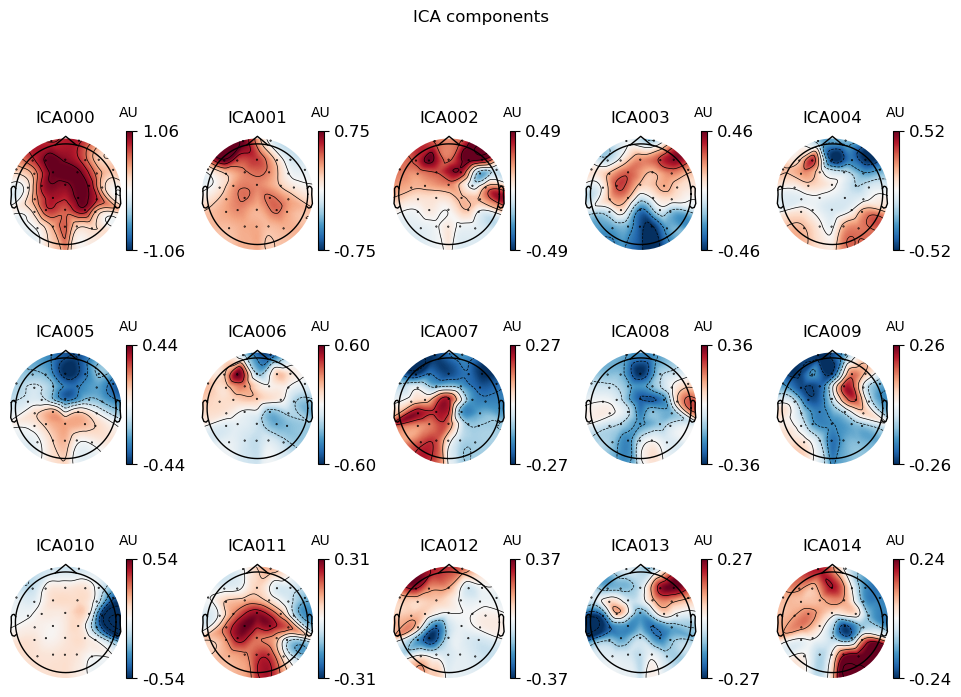

In [213]:
test.init_ICA()
test.plot_sources()

In [129]:
#test.plot_properties([10])

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components


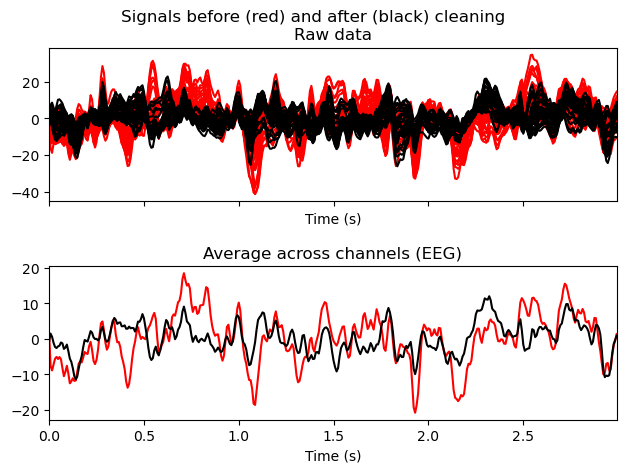

In [208]:
test.test_exclude([0,1,3])

In [210]:
test.exclude_ICA([0,1,3])
test.plot('raw')
test.plot('reconstructed')

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components
(array([[ 1.1274077 , -4.9742264 , -4.52113542, ..., -1.69798117,
         1.21487132,  1.64664884]]), array([0.00000000e+00, 7.81250000e-03, 1.56250000e-02, ...,
       2.49765625e+01, 2.49843750e+01, 2.49921875e+01]))
(array([[-2.09182337,  7.44956099,  8.6379554 , ..., -2.86279683,
        -2.91902773, -1.21591834]]), array([0.00000000e+00, 7.81250000e-03, 1.56250000e-02, ...,
       2.49765625e+01, 2.49843750e+01, 2.49921875e+01]))


Channels marked as bad:
none
Channels marked as bad:
none


In [27]:
#test.plot('raw', save=True)
#test.plot('filtered', save=True)
#test.plot('ica', save=True)
#test.plot('reconstructed', save=True)

In [211]:
test.save_data()